In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, log_loss

In [2]:
%matplotlib inline

In [3]:
train_df = pd.read_json('../data/train.json')

In [4]:
len(train_df)

49352

In [5]:
train_df

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,6894514,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street
100016,1.0,2,3ba49a93260ca5df92fde024cb4ca61f,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,"[prewar, elevator, Dogs Allowed, Cats Allowed,...",low,40.8012,6930771,-73.9660,01287194f20de51872e81f660def4784,[https://photos.renthop.com/2/6930771_7e3622b6...,3600,210 West 107th Street
100020,2.0,1,0372927bcb6a0949613ef5bf893bbac7,2016-04-13 06:01:42,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,"[Doorman, Elevator, Pre-War, Terrace, Laundry ...",low,40.7427,6867392,-73.9957,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/6867392_b18283f6...,5645,155 West 21st Street
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,6898799,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace
100027,2.0,4,0,2016-04-02 02:58:15,This is a spacious four bedroom with every bed...,522 E 11th,"[Dishwasher, Hardwood Floors]",low,40.7278,6814332,-73.9808,23a01ea7717b38875f5b070282d1b9d2,[https://photos.renthop.com/2/6814332_e19a8552...,5800,522 E 11th


In [6]:
def add_basic_features(train_df):
    train_df["num_photos"] = train_df["photos"].apply(len)
    train_df["num_features"] = train_df["features"].apply(len)
    train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
    train_df["created"] = pd.to_datetime(train_df["created"])
    train_df["created_year"] = train_df["created"].dt.year
    train_df["created_month"] = train_df["created"].dt.month
    train_df["created_day"] = train_df["created"].dt.day

add_basic_features(train_df)

In [7]:
def get_flat_features(df):
    import operator
    from collections import Counter
    
    counter = Counter()
    for _, item in df['features'].iteritems():
        counter.update(item)
        
    most_popular_features = \
        [k for k, v in sorted(counter.items(), key=operator.itemgetter(1), reverse=True)][:20]
    
    print(most_popular_features)
    
    features_str = df['features'].apply(lambda f: '|'.join(f))
    
    return pd.concat(
        [features_str.str.contains(f).rename(f) for f in most_popular_features],
        axis=1)

flat_features = get_flat_features(train_df)

['Elevator', 'Cats Allowed', 'Hardwood Floors', 'Dogs Allowed', 'Doorman', 'Dishwasher', 'No Fee', 'Laundry in Building', 'Fitness Center', 'Pre-War', 'Laundry in Unit', 'Roof Deck', 'Outdoor Space', 'Dining Room', 'High Speed Internet', 'Balcony', 'Swimming Pool', 'Laundry In Building', 'New Construction', 'Terrace']


In [8]:
train_df = pd.concat([train_df, flat_features], axis=1)

In [9]:
features = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 
            'price', 'num_photos', 'num_features', 'num_description_words',
            'created_year', 'created_month', 'created_day'] + list(flat_features.columns)

In [10]:
X = train_df[features]

In [11]:
y = train_df['interest_level']

In [12]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.7)

In [13]:
cls = RandomForestClassifier(n_estimators=300).fit(train_X, train_y)

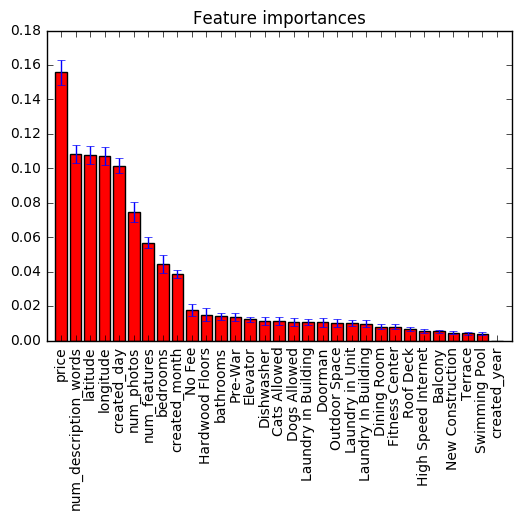

In [14]:
def plot_importances(forest, X, features):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), [features[fid] for fid in indices],
              rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.show()

plot_importances(cls, train_X, features)

In [26]:
prediction = cls.predict(test_X)
prediction_proba = cls.predict_proba(test_X)

In [27]:
print(classification_report(test_y, prediction))

             precision    recall  f1-score   support

       high       0.50      0.23      0.31      1145
        low       0.77      0.94      0.85     10276
     medium       0.46      0.24      0.31      3385

avg / total       0.68      0.72      0.68     14806



In [28]:
print(log_loss(test_y, prediction_proba))

0.619817513593


### create submission

In [29]:
test_df = pd.read_json('../data/test.json')

In [30]:
add_basic_features(test_df)

In [31]:
test_df = pd.concat([test_df,  get_flat_features(test_df)], axis=1)

['Elevator', 'Cats Allowed', 'Hardwood Floors', 'Dogs Allowed', 'Doorman', 'Dishwasher', 'No Fee', 'Laundry in Building', 'Fitness Center', 'Pre-War', 'Laundry in Unit', 'Roof Deck', 'Outdoor Space', 'Dining Room', 'High Speed Internet', 'Balcony', 'Swimming Pool', 'Laundry In Building', 'New Construction', 'Terrace']


In [32]:
clf = RandomForestClassifier(n_estimators=300).fit(X, y)

In [33]:
test_prediction = clf.predict_proba(test_df[features])

In [34]:
labels2idx = {label: i for i, label in enumerate(clf.classes_)}
sub = pd.DataFrame()
sub["listing_id"] = test_df["listing_id"]
for label in ["high", "medium", "low"]:
    sub[label] = test_prediction[:, labels2idx[label]]

In [35]:
sub.to_csv("first_sub.csv", index=False)